In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/AMS2022')


#install library ekphrasis

In [3]:
!pip install ekphrasis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number'],
    # terms that will be annotated
    #annotate={"hashtag", "allcaps", "elongated", "repeated",'emphasis', 'censored'},
    annotate={"hashtag","allcaps","elongated","repeated",'emphasis','censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

/usr/local/lib/python3.8/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...


/usr/local/lib/python3.8/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...


#Load Library

In [5]:
import re
import string 
import pandas as pd
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#Load dataset mentah

In [6]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AMS2022/STB_baru.csv', sep=',')  

#cek info

In [7]:
df.head()

,Tweets,cleanedTweets,Translated,Subjectivity,Polarity,Analysis
0,"Mulai 20 Desember 2022 pukul 24.00 WIB, siaran...","mulai 20 desember 2022 pukul 24.00 wib, siaran...","Starting December 2022 at 24.00 WIB, analog br...",0.05,0.0,0
1,@hyang_wisnu @kemkominfo @jokowi @PlateJohnny ...,…,…,0.00,0.0,0
2,Lembaga penyiaran bersepakat melaksanakan peng...,lembaga penyiaran bersepakat melaksanakan peng...,Broadcasting Institution agreed to carry out a...,0.00,0.0,0
3,RT @hyang_wisnu: HARI INI TV ANALOG DIMATIKAN ...,hari ini tv analog dimatikan di 10 wilayah jaw...,Today analog TV is turned off in 10 regions of...,0.00,0.0,0
4,Per tanggal 20 Desember 2022 pada pukul 24.00 ...,per tanggal 20 desember 2022 pada pukul 24.00 ...,"As of December 20, 2022 at 24.00 WIB, analog T...",0.00,0.0,0


In [8]:
df

,Tweets,cleanedTweets,Translated,Subjectivity,Polarity,Analysis
0,"Mulai 20 Desember 2022 pukul 24.00 WIB, siaran...","mulai 20 desember 2022 pukul 24.00 wib, siaran...","Starting December 2022 at 24.00 WIB, analog br...",0.05,0.00,0
1,@hyang_wisnu @kemkominfo @jokowi @PlateJohnny ...,…,…,0.00,0.00,0
2,Lembaga penyiaran bersepakat melaksanakan peng...,lembaga penyiaran bersepakat melaksanakan peng...,Broadcasting Institution agreed to carry out a...,0.00,0.00,0
3,RT @hyang_wisnu: HARI INI TV ANALOG DIMATIKAN ...,hari ini tv analog dimatikan di 10 wilayah jaw...,Today analog TV is turned off in 10 regions of...,0.00,0.00,0
4,Per tanggal 20 Desember 2022 pada pukul 24.00 ...,per tanggal 20 desember 2022 pada pukul 24.00 ...,"As of December 20, 2022 at 24.00 WIB, analog T...",0.00,0.00,0
...,...,...,...,...,...,...
288,@jokowi semoga dengan adanya peralihan saluran...,semoga dengan adanya peralihan saluran tv dig...,Hopefully with the transition of this digital ...,0.25,-0.25,-1
289,@masyogpam Iya harusnya kalo tvnya dah digital...,"iya harusnya kalo tvnya dah digital ya, anten...","Yes, it should be if the TV is digital, UHF an...",0.50,0.00,0
290,@kemkominfo Imbau Warga Jawa Timur Segera Pasa...,imbau warga jawa timur segera pasang stb jela...,IMPAU East Java citizens immediately installed...,0.40,-0.20,-1
291,Masyarakat Surabaya dan sekitarnya akan merasa...,masyarakat surabaya dan sekitarnya akan merasa...,The people of Surabaya and its surroundings wi...,0.40,0.20,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Tweets         293 non-null    object 
 1   cleanedTweets  292 non-null    object 
 2   Translated     292 non-null    object 
 3   Subjectivity   293 non-null    float64
 4   Polarity       293 non-null    float64
 5   Analysis       293 non-null    int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 13.9+ KB


###Sisakan column Tweets dan Analysis (label)

In [10]:
del df['cleanedTweets']
del df['Translated']
del df['Subjectivity']
del df['Polarity']

In [11]:
#create a function to check negative, neutral and positive analysis
def getAnalysis(score):
    if score == -1:
        return '0'
    elif score == 0:
        return '1'
    else:
        return '2'
    
df['Label'] = df['Analysis'].apply(getAnalysis)

In [12]:
df.head()

,Tweets,Analysis,Label
0,"Mulai 20 Desember 2022 pukul 24.00 WIB, siaran...",0,1
1,@hyang_wisnu @kemkominfo @jokowi @PlateJohnny ...,0,1
2,Lembaga penyiaran bersepakat melaksanakan peng...,0,1
3,RT @hyang_wisnu: HARI INI TV ANALOG DIMATIKAN ...,0,1
4,Per tanggal 20 Desember 2022 pada pukul 24.00 ...,0,1


In [13]:
del df['Analysis']

#Preprocessing

##setting fungsi

In [14]:
def bersih_data(text):
    return " ".join(text_processor.pre_process_doc(text))

def non_ascii(text):
    return text.encode('ascii', 'replace').decode('ascii')

def remove_space_alzami(text):
    return " ".join(text.split())

def remove_emoji_alzami(text):
    return ' '.join(re.sub("([x#][A-Za-z0-9]+)"," ", text).split())

def remove_tab(text):
    return text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")

def remove_tab2(text):
    return re.sub('\s+',' ',text)

def remove_rt(text):
    return text.replace('RT'," ").replace('RT :[\s]+'," ")

def remove_mention(text):
    return ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())

def remove_incomplete_url(text):
    text = re.sub('https?:\/\/\S+', '', text)
    text = re.sub('http?:\/\/\S+', '', text)
    return text

def remove_single_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

def change_stripe(text):
    return text.replace('-'," ")

def lower(text):
    return text.lower()

def remove_punctuation(text):
    remove = string.punctuation
    remove = remove.replace("_", "") # don't remove hyphens
    pattern = r"[{}]".format(remove) # create the pattern
    return re.sub(pattern, "", text) 

##running preprocessing

In [15]:
final_string = []
for text in df['Tweets'].values:
    EachReviewText = ""
    proc = bersih_data(text)
    proc = remove_rt(proc) 
    proc = lower(proc)
    proc = change_stripe(proc)
    proc = remove_tab(proc)
    proc = remove_tab2(proc)
    proc = non_ascii(proc)
    proc = remove_incomplete_url(proc)
    proc = remove_single_char(proc)
    proc = remove_punctuation(proc)
    proc = remove_space_alzami(proc)
    EachReviewText = proc
    final_string.append(EachReviewText)

In [16]:
df["step01"] = final_string

In [17]:
df.head()

,Tweets,Label,step01
0,"Mulai 20 Desember 2022 pukul 24.00 WIB, siaran...",1,mulai number desember number pukul number allc...
1,@hyang_wisnu @kemkominfo @jokowi @PlateJohnny ...,1,user user user user user user user user user
2,Lembaga penyiaran bersepakat melaksanakan peng...,1,lembaga penyiaran bersepakat melaksanakan peng...
3,RT @hyang_wisnu: HARI INI TV ANALOG DIMATIKAN ...,1,rt user allcaps hari ini tv analog dimatikan d...
4,Per tanggal 20 Desember 2022 pada pukul 24.00 ...,1,per tanggal number desember number pada pukul ...


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweets  293 non-null    object
 1   Label   293 non-null    object
 2   step01  293 non-null    object
dtypes: object(3)
memory usage: 7.0+ KB


##hapus record yang kosong dan redundan

In [19]:
df_hapus = df[~df['step01'].str.contains(" ")]

In [20]:
df_new = df[~df.isin(df_hapus)].dropna()

In [21]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 0 to 292
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweets  292 non-null    object
 1   Label   292 non-null    object
 2   step01  292 non-null    object
dtypes: object(3)
memory usage: 9.1+ KB


In [22]:
df_new.drop_duplicates(inplace=True)

In [23]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 0 to 292
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweets  292 non-null    object
 1   Label   292 non-null    object
 2   step01  292 non-null    object
dtypes: object(3)
memory usage: 9.1+ KB


In [24]:
df_new.shape

(292, 3)

##normalisasi kata slang

In [25]:
# token
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [26]:
def word_tokenize_wrapper(text):
  return word_tokenize(text)

In [27]:
df_new['tokens'] = df['step01'].apply(word_tokenize_wrapper)

In [28]:
df_new.head(5)

,Tweets,Label,step01,tokens
0,"Mulai 20 Desember 2022 pukul 24.00 WIB, siaran...",1,mulai number desember number pukul number allc...,"[mulai, number, desember, number, pukul, numbe..."
1,@hyang_wisnu @kemkominfo @jokowi @PlateJohnny ...,1,user user user user user user user user user,"[user, user, user, user, user, user, user, use..."
2,Lembaga penyiaran bersepakat melaksanakan peng...,1,lembaga penyiaran bersepakat melaksanakan peng...,"[lembaga, penyiaran, bersepakat, melaksanakan,..."
3,RT @hyang_wisnu: HARI INI TV ANALOG DIMATIKAN ...,1,rt user allcaps hari ini tv analog dimatikan d...,"[rt, user, allcaps, hari, ini, tv, analog, dim..."
4,Per tanggal 20 Desember 2022 pada pukul 24.00 ...,1,per tanggal number desember number pada pukul ...,"[per, tanggal, number, desember, number, pada,..."


In [29]:
normalized_word = pd.read_excel("/content/drive/My Drive/Colab Notebooks/AMS2022/kamus perbaikan kata.xlsx")

normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]

df_new['tokens_perbaikan'] = df_new['tokens'].apply(normalized_term)

In [30]:
df_new.head()

,Tweets,Label,step01,tokens,tokens_perbaikan
0,"Mulai 20 Desember 2022 pukul 24.00 WIB, siaran...",1,mulai number desember number pukul number allc...,"[mulai, number, desember, number, pukul, numbe...","[mulai, number, desember, number, pukul, numbe..."
1,@hyang_wisnu @kemkominfo @jokowi @PlateJohnny ...,1,user user user user user user user user user,"[user, user, user, user, user, user, user, use...","[user, user, user, user, user, user, user, use..."
2,Lembaga penyiaran bersepakat melaksanakan peng...,1,lembaga penyiaran bersepakat melaksanakan peng...,"[lembaga, penyiaran, bersepakat, melaksanakan,...","[lembaga, penyiaran, bersepakat, melaksanakan,..."
3,RT @hyang_wisnu: HARI INI TV ANALOG DIMATIKAN ...,1,rt user allcaps hari ini tv analog dimatikan d...,"[rt, user, allcaps, hari, ini, tv, analog, dim...","[rt, user, allcaps, hari, ini, tv, analog, dim..."
4,Per tanggal 20 Desember 2022 pada pukul 24.00 ...,1,per tanggal number desember number pada pukul ...,"[per, tanggal, number, desember, number, pada,...","[per, tanggal, number, desember, number, pada,..."


In [31]:
df_new.iloc[0].tokens

['mulai',
 'number',
 'desember',
 'number',
 'pukul',
 'number',
 'allcaps',
 'wib',
 'allcaps',
 'siaran',
 'analog',
 'di',
 'number',
 'wilayah',
 'jawa',
 'timur',
 'number',
 'tv',
 'akan',
 'dimatikan',
 'selanjutnya',
 'ma']

In [32]:
df_new.iloc[0].tokens_perbaikan

['mulai',
 'number',
 'desember',
 'number',
 'pukul',
 'number',
 'allcaps',
 'wib',
 'allcaps',
 'siaran',
 'analog',
 'di',
 'number',
 'wilayah',
 'jawa',
 'timur',
 'number',
 'tv',
 'akan',
 'dimatikan',
 'selanjutnya',
 'sama']

##Stopword - Menggunakan Modul NLTK

In [33]:
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
stopword = nltk.corpus.stopwords.words('indonesian')

def remove_stopwords(text):
  text = [word for word in text if word not in stopword]
  return text

df_new['Stop_removal'] = df_new['tokens_perbaikan'].apply(lambda x: remove_stopwords(x))
df_new

,Tweets,Label,step01,tokens,tokens_perbaikan,Stop_removal
0,"Mulai 20 Desember 2022 pukul 24.00 WIB, siaran...",1,mulai number desember number pukul number allc...,"[mulai, number, desember, number, pukul, numbe...","[mulai, number, desember, number, pukul, numbe...","[number, desember, number, number, allcaps, wi..."
1,@hyang_wisnu @kemkominfo @jokowi @PlateJohnny ...,1,user user user user user user user user user,"[user, user, user, user, user, user, user, use...","[user, user, user, user, user, user, user, use...","[user, user, user, user, user, user, user, use..."
2,Lembaga penyiaran bersepakat melaksanakan peng...,1,lembaga penyiaran bersepakat melaksanakan peng...,"[lembaga, penyiaran, bersepakat, melaksanakan,...","[lembaga, penyiaran, bersepakat, melaksanakan,...","[lembaga, penyiaran, bersepakat, melaksanakan,..."
3,RT @hyang_wisnu: HARI INI TV ANALOG DIMATIKAN ...,1,rt user allcaps hari ini tv analog dimatikan d...,"[rt, user, allcaps, hari, ini, tv, analog, dim...","[rt, user, allcaps, hari, ini, tv, analog, dim...","[rt, user, allcaps, tv, analog, dimatikan, all..."
4,Per tanggal 20 Desember 2022 pada pukul 24.00 ...,1,per tanggal number desember number pada pukul ...,"[per, tanggal, number, desember, number, pada,...","[per, tanggal, number, desember, number, pada,...","[tanggal, number, desember, number, number, al..."
...,...,...,...,...,...,...
288,@jokowi semoga dengan adanya peralihan saluran...,0,user semoga dengan adanya peralihan saluran tv...,"[user, semoga, dengan, adanya, peralihan, salu...","[user, semoga, dengan, adanya, peralihan, salu...","[user, semoga, peralihan, saluran, tv, digital..."
289,@masyogpam Iya harusnya kalo tvnya dah digital...,1,user iya harusnya kalo tvnya dah digital ya an...,"[user, iya, harusnya, kalo, tvnya, dah, digita...","[user, iya, harusnya, kalau, tvnya, sudah, dig...","[user, iya, tvnya, digital, iya, antena, uhf, ..."
290,@kemkominfo Imbau Warga Jawa Timur Segera Pasa...,0,user imbau warga jawa timur segera pasang allc...,"[user, imbau, warga, jawa, timur, segera, pasa...","[user, imbau, warga, jawa, timur, segera, pasa...","[user, imbau, warga, jawa, timur, pasang, allc..."
291,Masyarakat Surabaya dan sekitarnya akan merasa...,2,masyarakat surabaya dan sekitarnya akan merasa...,"[masyarakat, surabaya, dan, sekitarnya, akan, ...","[masyarakat, surabaya, dan, sekitarnya, akan, ...","[masyarakat, surabaya, merasakan, nikmatnya, t..."


In [35]:
df_new.iloc[0].tokens_perbaikan

['mulai',
 'number',
 'desember',
 'number',
 'pukul',
 'number',
 'allcaps',
 'wib',
 'allcaps',
 'siaran',
 'analog',
 'di',
 'number',
 'wilayah',
 'jawa',
 'timur',
 'number',
 'tv',
 'akan',
 'dimatikan',
 'selanjutnya',
 'sama']

In [36]:
df_new.iloc[0].Stop_removal

['number',
 'desember',
 'number',
 'number',
 'allcaps',
 'wib',
 'allcaps',
 'siaran',
 'analog',
 'number',
 'wilayah',
 'jawa',
 'timur',
 'number',
 'tv',
 'dimatikan']

In [37]:
i=0
final_string_tokens = []
for text in df_new['Stop_removal'].values:
    EachReviewText = ""
    EachReviewText = ' '.join(text)
    final_string_tokens.append(EachReviewText)

In [38]:
df_new["step02"] = final_string_tokens

In [39]:
df_new.head()

,Tweets,Label,step01,tokens,tokens_perbaikan,Stop_removal,step02
0,"Mulai 20 Desember 2022 pukul 24.00 WIB, siaran...",1,mulai number desember number pukul number allc...,"[mulai, number, desember, number, pukul, numbe...","[mulai, number, desember, number, pukul, numbe...","[number, desember, number, number, allcaps, wi...",number desember number number allcaps wib allc...
1,@hyang_wisnu @kemkominfo @jokowi @PlateJohnny ...,1,user user user user user user user user user,"[user, user, user, user, user, user, user, use...","[user, user, user, user, user, user, user, use...","[user, user, user, user, user, user, user, use...",user user user user user user user user user
2,Lembaga penyiaran bersepakat melaksanakan peng...,1,lembaga penyiaran bersepakat melaksanakan peng...,"[lembaga, penyiaran, bersepakat, melaksanakan,...","[lembaga, penyiaran, bersepakat, melaksanakan,...","[lembaga, penyiaran, bersepakat, melaksanakan,...",lembaga penyiaran bersepakat melaksanakan peng...
3,RT @hyang_wisnu: HARI INI TV ANALOG DIMATIKAN ...,1,rt user allcaps hari ini tv analog dimatikan d...,"[rt, user, allcaps, hari, ini, tv, analog, dim...","[rt, user, allcaps, hari, ini, tv, analog, dim...","[rt, user, allcaps, tv, analog, dimatikan, all...",rt user allcaps tv analog dimatikan allcaps nu...
4,Per tanggal 20 Desember 2022 pada pukul 24.00 ...,1,per tanggal number desember number pada pukul ...,"[per, tanggal, number, desember, number, pada,...","[per, tanggal, number, desember, number, pada,...","[tanggal, number, desember, number, number, al...",tanggal number desember number number allcaps ...


##Stemming - Menggunakan Sastrawi

In [40]:
!pip install sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [42]:
final_string = []
s = ""
for sentence in df_new["step02"].values:
    filteredSentence = []
    EachReviewText = ""
    s = (stemmer.stem(sentence))
    filteredSentence.append(s)
    
    EachReviewText = ' '.join(filteredSentence)
    final_string.append(EachReviewText)

In [43]:
df_new["ProcessedText"] = final_string

In [44]:
df_new.head(5)

,Tweets,Label,step01,tokens,tokens_perbaikan,Stop_removal,step02,ProcessedText
0,"Mulai 20 Desember 2022 pukul 24.00 WIB, siaran...",1,mulai number desember number pukul number allc...,"[mulai, number, desember, number, pukul, numbe...","[mulai, number, desember, number, pukul, numbe...","[number, desember, number, number, allcaps, wi...",number desember number number allcaps wib allc...,number desember number number allcaps wib allc...
1,@hyang_wisnu @kemkominfo @jokowi @PlateJohnny ...,1,user user user user user user user user user,"[user, user, user, user, user, user, user, use...","[user, user, user, user, user, user, user, use...","[user, user, user, user, user, user, user, use...",user user user user user user user user user,user user user user user user user user user
2,Lembaga penyiaran bersepakat melaksanakan peng...,1,lembaga penyiaran bersepakat melaksanakan peng...,"[lembaga, penyiaran, bersepakat, melaksanakan,...","[lembaga, penyiaran, bersepakat, melaksanakan,...","[lembaga, penyiaran, bersepakat, melaksanakan,...",lembaga penyiaran bersepakat melaksanakan peng...,lembaga siar sepakat laksana henti siar analog...
3,RT @hyang_wisnu: HARI INI TV ANALOG DIMATIKAN ...,1,rt user allcaps hari ini tv analog dimatikan d...,"[rt, user, allcaps, hari, ini, tv, analog, dim...","[rt, user, allcaps, hari, ini, tv, analog, dim...","[rt, user, allcaps, tv, analog, dimatikan, all...",rt user allcaps tv analog dimatikan allcaps nu...,rt user allcaps tv analog mati allcaps number ...
4,Per tanggal 20 Desember 2022 pada pukul 24.00 ...,1,per tanggal number desember number pada pukul ...,"[per, tanggal, number, desember, number, pada,...","[per, tanggal, number, desember, number, pada,...","[tanggal, number, desember, number, number, al...",tanggal number desember number number allcaps ...,tanggal number desember number number allcaps ...


##simpan hasil preprocessing

In [45]:
df_new.to_csv('/content/drive/My Drive/Colab Notebooks/clean_dataset_uas.csv', sep=";")

##Penataan Data
pembagian fitur dan label

In [46]:
import pandas as pd
import numpy as np

In [47]:
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/clean_dataset_uas_stb.csv', sep=";")

In [48]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        250 non-null    int64 
 1   Tweets            250 non-null    object
 2   Label             250 non-null    int64 
 3   step01            250 non-null    object
 4   tokens            250 non-null    object
 5   tokens_perbaikan  250 non-null    object
 6   Stop_removal      250 non-null    object
 7   step02            250 non-null    object
 8   ProcessedText     250 non-null    object
dtypes: int64(2), object(7)
memory usage: 17.7+ KB


In [49]:
dataset

,Unnamed: 0,Tweets,Label,step01,tokens,tokens_perbaikan,Stop_removal,step02,ProcessedText
0,0,"Mulai 20 Desember 2022 pukul 24.00 WIB, siaran...",1,mulai number desember number pukul number allc...,"['mulai', 'number', 'desember', 'number', 'puk...","['mulai', 'number', 'desember', 'number', 'puk...","['number', 'desember', 'number', 'number', 'al...",number desember number number allcaps wib allc...,number desember number number allcaps wib allc...
1,2,Lembaga penyiaran bersepakat melaksanakan peng...,1,lembaga penyiaran bersepakat melaksanakan peng...,"['lembaga', 'penyiaran', 'bersepakat', 'melaks...","['lembaga', 'penyiaran', 'bersepakat', 'melaks...","['lembaga', 'penyiaran', 'bersepakat', 'melaks...",lembaga penyiaran bersepakat melaksanakan peng...,lembaga siar sepakat laksana henti siar analog...
2,3,HARI INI TV ANALOG DIMATIKAN DI 10 WILAYAH JAW...,1,allcaps hari ini tv analog dimatikan di allcap...,"['allcaps', 'hari', 'ini', 'tv', 'analog', 'di...","['allcaps', 'hari', 'ini', 'tv', 'analog', 'di...","['allcaps', 'tv', 'analog', 'dimatikan', 'allc...",allcaps tv analog dimatikan allcaps number all...,allcaps tv analog mati allcaps number allcaps ...
3,4,Per tanggal 20 Desember 2022 pada pukul 24.00 ...,1,per tanggal number desember number pada pukul ...,"['per', 'tanggal', 'number', 'desember', 'numb...","['per', 'tanggal', 'number', 'desember', 'numb...","['tanggal', 'number', 'desember', 'number', 'n...",tanggal number desember number number allcaps ...,tanggal number desember number number allcaps ...
4,8,"Tv analog dimatikan, tv sinyal digital tidak m...",0,tv analog dimatikan tv sinyal digital tidak me...,"['tv', 'analog', 'dimatikan', 'tv', 'sinyal', ...","['tv', 'analog', 'dimatikan', 'tv', 'sinyal', ...","['tv', 'analog', 'dimatikan', 'tv', 'sinyal', ...",tv analog dimatikan tv sinyal digital merata r...,tv analog mati tv sinyal digital rata repeated...
...,...,...,...,...,...,...,...,...,...
245,287,"TV digital sgt tdk maksimal, harga stb yg ban...",1,tv digital sgt tdk maksimal harga stb yg banya...,"['tv', 'digital', 'sgt', 'tdk', 'maksimal', 'h...","['tv', 'digital', 'sangat', 'tidak', 'maksimal...","['tv', 'digital', 'maksimal', 'harga', 'stb', ...",tv digital maksimal harga stb pro kontra masya...,tv digital maksimal harga stb pro kontra masya...
246,289,"Iya harusnya kalo tvnya dah digital ya, anten...",1,iya harusnya kalo tvnya dah digital ya antena ...,"['iya', 'harusnya', 'kalo', 'tvnya', 'dah', 'd...","['iya', 'harusnya', 'kalau', 'tvnya', 'sudah',...","['iya', 'tvnya', 'digital', 'iya', 'antena', '...",iya tvnya digital iya antena uhf nangkep sinya...,iya tvnya digital iya antena uhf nangkep sinya...
247,290,Imbau Warga Jawa Timur Segera Pasang STB Jela...,0,imbau warga jawa timur segera pasang allcaps s...,"['imbau', 'warga', 'jawa', 'timur', 'segera', ...","['imbau', 'warga', 'jawa', 'timur', 'segera', ...","['imbau', 'warga', 'jawa', 'timur', 'pasang', ...",imbau warga jawa timur pasang allcaps stb allc...,imbau warga jawa timur pasang allcaps stb allc...
248,291,Masyarakat Surabaya dan sekitarnya akan merasa...,2,masyarakat surabaya dan sekitarnya akan merasa...,"['masyarakat', 'surabaya', 'dan', 'sekitarnya'...","['masyarakat', 'surabaya', 'dan', 'sekitarnya'...","['masyarakat', 'surabaya', 'merasakan', 'nikma...",masyarakat surabaya merasakan nikmatnya teknol...,masyarakat surabaya rasa nikmat teknologi tv d...


In [50]:
dataset_feature = dataset['ProcessedText'].astype(str)

In [51]:
dataset_feature.head(10)

0    number desember number number allcaps wib allc...
1    lembaga siar sepakat laksana henti siar analog...
2    allcaps tv analog mati allcaps number allcaps ...
3    tanggal number desember number number allcaps ...
4    tv analog mati tv sinyal digital rata repeated...
5    beli nijoo digital set top box tv digital rece...
6    tonton tv digital iring bijak allcaps aso allc...
7    suntik mati tv analog jatim cek sinyal tv digi...
8    tv analog mati number wilayah jawa timur tangg...
9    allcaps tv analog mati allcaps number allcaps ...
Name: ProcessedText, dtype: object

In [52]:
dataset_label = dataset['Label']

In [53]:
dataset_label.head(10)

0    1
1    1
2    1
3    1
4    0
5    2
6    2
7    1
8    1
9    1
Name: Label, dtype: int64

In [54]:
dataset_label.value_counts()

2    124
1     63
0     63
Name: Label, dtype: int64

##distribusi label

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


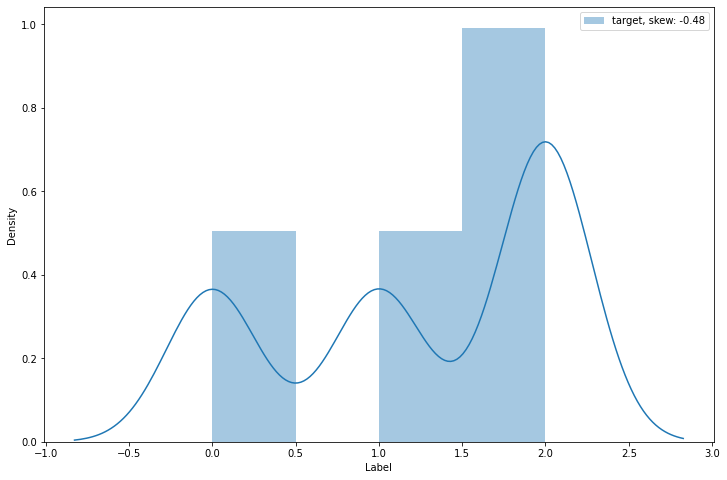

In [56]:
# Visualizing the target variable
plt.figure(figsize=(12,8))
sns.distplot(dataset_label, label=f'target, skew: {dataset_label.skew():.2f}')
plt.legend(loc='best')
plt.show()

Kesimpulan dataset : Data yang digunakan merupakan data yang seimbang karena persebaran label tidak menunjukkan adanya ketimpangan sehingga dataset ini sudah cukup mewakili dari masing masing sentimen baik positif, netral, negatif

In [57]:
dataset_label.value_counts()

2    124
1     63
0     63
Name: Label, dtype: int64

##Ekstraksi Fitur dan Machine Learning

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

In [59]:
train_x, test_x, train_label, test_label = train_test_split(dataset_feature, dataset_label, test_size = 0.5, random_state=42)

In [60]:
test_x

142               maaf harga stb lonjak iya harga solusi
6      tonton tv digital iring bijak allcaps aso allc...
97     atur perintah pakai allcaps stb allcaps set to...
60                           beli set top box tv digital
112    kominfo data kini realisasi distribusi set top...
                             ...                        
127    harga allcaps bbm allcaps harga sembako tambah...
150                               harga stb rakyat jerit
248    masyarakat surabaya rasa nikmat teknologi tv d...
90     khawatir tonton tv video cuaca buruk gambar su...
85     kunci sukses laksana migrasi tv analog digital...
Name: ProcessedText, Length: 125, dtype: object

##load TF-IDF

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_Vectorizer = TfidfVectorizer()

In [62]:
positive_reviews = dataset[(dataset["Label"] == 2)]
negative_reviews = dataset[(dataset["Label"] == 0)]
neutral_reviews = dataset[(dataset["Label"] == 1)]

##cek emosi neutral low

In [63]:
neutral_reviews.head()

,Unnamed: 0,Tweets,Label,step01,tokens,tokens_perbaikan,Stop_removal,step02,ProcessedText
0,0,"Mulai 20 Desember 2022 pukul 24.00 WIB, siaran...",1,mulai number desember number pukul number allc...,"['mulai', 'number', 'desember', 'number', 'puk...","['mulai', 'number', 'desember', 'number', 'puk...","['number', 'desember', 'number', 'number', 'al...",number desember number number allcaps wib allc...,number desember number number allcaps wib allc...
1,2,Lembaga penyiaran bersepakat melaksanakan peng...,1,lembaga penyiaran bersepakat melaksanakan peng...,"['lembaga', 'penyiaran', 'bersepakat', 'melaks...","['lembaga', 'penyiaran', 'bersepakat', 'melaks...","['lembaga', 'penyiaran', 'bersepakat', 'melaks...",lembaga penyiaran bersepakat melaksanakan peng...,lembaga siar sepakat laksana henti siar analog...
2,3,HARI INI TV ANALOG DIMATIKAN DI 10 WILAYAH JAW...,1,allcaps hari ini tv analog dimatikan di allcap...,"['allcaps', 'hari', 'ini', 'tv', 'analog', 'di...","['allcaps', 'hari', 'ini', 'tv', 'analog', 'di...","['allcaps', 'tv', 'analog', 'dimatikan', 'allc...",allcaps tv analog dimatikan allcaps number all...,allcaps tv analog mati allcaps number allcaps ...
3,4,Per tanggal 20 Desember 2022 pada pukul 24.00 ...,1,per tanggal number desember number pada pukul ...,"['per', 'tanggal', 'number', 'desember', 'numb...","['per', 'tanggal', 'number', 'desember', 'numb...","['tanggal', 'number', 'desember', 'number', 'n...",tanggal number desember number number allcaps ...,tanggal number desember number number allcaps ...
7,12,"Suntik Mati TV Analog Jatim Hari Ini, Begini C...",1,suntik mati tv analog jatim hari ini begini ca...,"['suntik', 'mati', 'tv', 'analog', 'jatim', 'h...","['suntik', 'mati', 'tv', 'analog', 'jatim', 'h...","['suntik', 'mati', 'tv', 'analog', 'jatim', 'c...",suntik mati tv analog jatim cek sinyal tv digi...,suntik mati tv analog jatim cek sinyal tv digi...


In [64]:
Neutral_1_tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
Neutral_1_tf_idf = Neutral_1_tf_idf_vect.fit_transform(neutral_reviews["ProcessedText"].values)

In [65]:
Neutral_1_tf_idf.shape

(63, 204)

In [66]:
features = Neutral_1_tf_idf_vect.get_feature_names()

idfValues = Neutral_1_tf_idf_vect.idf_

d = dict(zip(features, 9 - idfValues))

sortedDict = sorted(d.items(), key = lambda d: d[1], reverse = True)

for i in range(200):
    print(sortedDict[i])

('tv', 7.647779406410648)
('digital', 7.424635855096438)
('allcaps', 7.36747744125649)
('siar', 7.337624478106808)
('analog', 6.836849190194319)
('stb', 6.836849190194319)
('aspirasi', 6.4801742462555865)
('dpd', 6.4801742462555865)
('harga', 6.4801742462555865)
('ketua', 6.4801742462555865)
('number', 6.4801742462555865)
('perangkat', 6.4801742462555865)
('terima', 6.4801742462555865)
('batas', 6.406066274101865)
('jatim', 6.406066274101865)
('monitoring', 6.406066274101865)
('desember', 6.239012189438698)
('kpid', 6.239012189438698)
('mati', 6.239012189438698)
('wilayah', 6.1437020096343735)
('jawa', 5.920558458320164)
('timur', 5.920558458320164)
('alih', 5.787027065695641)
('sinyal', 5.787027065695641)
('aso', 5.632876385868383)
('henti', 5.632876385868383)
('tanggal', 5.632876385868383)
('wib', 5.632876385868383)
('ganti', 5.450554829074429)
('iya', 5.450554829074429)
('lanyalla', 5.450554829074429)
('masyarakat', 5.450554829074429)
('nonton', 5.450554829074429)
('repeated', 5.450

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [67]:
from wordcloud import WordCloud
import matplotlib.pyplot as plot

In [68]:
def PlotWordCloud(frequency):
    worcloudPlot = WordCloud(background_color="white", width=1500, height=1000)
    worcloudPlot.generate_from_frequencies(frequencies=frequency)
    plot.figure(figsize=(15,10))
    plot.imshow(worcloudPlot, interpolation="bilinear")
    plot.axis("off")
    plot.show()

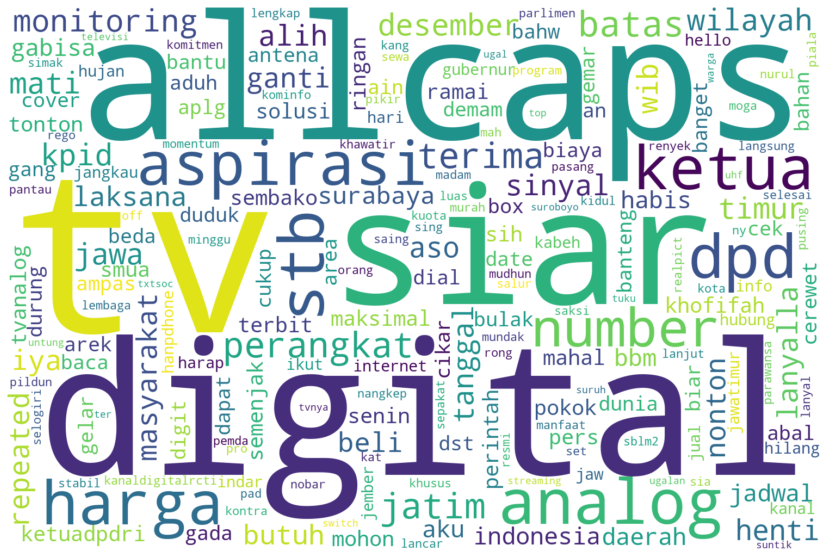

In [69]:
PlotWordCloud(d)

##cek emosi positive low

In [70]:
positive_reviews.head()

,Unnamed: 0,Tweets,Label,step01,tokens,tokens_perbaikan,Stop_removal,step02,ProcessedText
5,10,Beli Nijoo&amp;Digital Set Top Box TV Digital ...,2,beli nijoo digital set top box tv digital rece...,"['beli', 'nijoo', 'digital', 'set', 'top', 'bo...","['beli', 'nijoo', 'digital', 'set', 'top', 'bo...","['beli', 'nijoo', 'digital', 'set', 'top', 'bo...",beli nijoo digital set top box tv digital rece...,beli nijoo digital set top box tv digital rece...
6,11,"Adapun, untuk bisa menonton TV Digital seiring...",2,adapun untuk bisa menonton tv digital seiring ...,"['adapun', 'untuk', 'bisa', 'menonton', 'tv', ...","['adapun', 'untuk', 'bisa', 'menonton', 'tv', ...","['menonton', 'tv', 'digital', 'seiring', 'kebi...",menonton tv digital seiring kebijakan allcaps ...,tonton tv digital iring bijak allcaps aso allc...
19,24,Beli Set Top Box atau alat penerima siaran TV ...,2,beli set top box atau alat penerima siaran all...,"['beli', 'set', 'top', 'box', 'atau', 'alat', ...","['beli', 'set', 'top', 'box', 'atau', 'alat', ...","['beli', 'set', 'top', 'box', 'alat', 'penerim...",beli set top box alat penerima siaran allcaps ...,beli set top box alat terima siar allcaps tv d...
25,30,Hallo Penonton Setia tvOne! Isi Survey TV Dig...,2,hallo penonton setia tvone isi survey tv digit...,"['hallo', 'penonton', 'setia', 'tvone', 'isi',...","['hallo', 'penonton', 'setia', 'tvone', 'isi',...","['hallo', 'penonton', 'setia', 'tvone', 'isi',...",hallo penonton setia tvone isi survey tv digit...,hallo tonton setia tvone isi survey tv digital...
31,37,Mantap 👍 selamat menikmati siaran TV digital b...,2,mantap selamat menikmati siaran tv digital bag...,"['mantap', 'selamat', 'menikmati', 'siaran', '...","['mantap', 'selamat', 'menikmati', 'siaran', '...","['mantap', 'selamat', 'menikmati', 'siaran', '...",mantap selamat menikmati siaran tv digital mas...,mantap selamat nikmat siar tv digital masyarak...


In [71]:
Positive_1_tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
Positive_1_tf_idf = Positive_1_tf_idf_vect.fit_transform(positive_reviews["ProcessedText"].values)

In [72]:
Positive_1_tf_idf.shape

(124, 468)

In [73]:
features = Positive_1_tf_idf_vect.get_feature_names()

idfValues = Positive_1_tf_idf_vect.idf_

d = dict(zip(features, 9 - idfValues))

sortedDict = sorted(d.items(), key = lambda d: d[1], reverse = True)

for i in range(200):
    print(sortedDict[i])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


('tv', 7.7360344541655355)
('digital', 7.660322632429839)
('set', 7.314820989089231)
('allcaps', 7.266030824919799)
('top', 7.266030824919799)
('box', 7.249223706603418)
('stb', 7.232129273244118)
('number', 6.538982092684173)
('harga', 6.503890772872903)
('siar', 6.503890772872903)
('analog', 6.3905620875658995)
('beli', 6.11612524186414)
('hd', 5.810743592312957)
('pakai', 5.810743592312957)
('masyarakat', 5.736635620159236)
('gratis', 5.56958153549607)
('nikmat', 5.56958153549607)
('alih', 5.368910840033918)
('migrasi', 5.368910840033918)
('salur', 5.368910840033918)
('bantu', 5.251127804377535)
('dvb', 5.251127804377535)
('kunci', 5.251127804377535)
('laksana', 5.251127804377535)
('receiver', 5.251127804377535)
('salah', 5.251127804377535)
('sukses', 5.251127804377535)
('ayo', 5.117596411753012)
('hallo', 5.117596411753012)
('kominfo', 5.117596411753012)
('mati', 5.117596411753012)
('support', 5.117596411753012)
('t2', 5.117596411753012)
('terima', 5.117596411753012)
('tvone', 5.11

In [74]:
from wordcloud import WordCloud
import matplotlib.pyplot as plot

In [75]:
def PlotWordCloud(frequency):
    worcloudPlot = WordCloud(background_color="white", width=1500, height=1000)
    worcloudPlot.generate_from_frequencies(frequencies=frequency)
    plot.figure(figsize=(15,10))
    plot.imshow(worcloudPlot, interpolation="bilinear")
    plot.axis("off")
    plot.show()

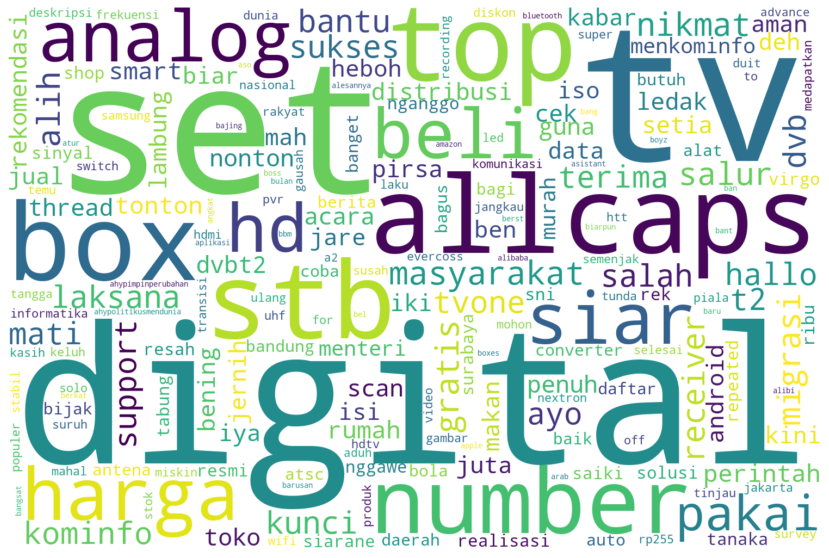

In [76]:
PlotWordCloud(d)

##cek emosi negative

In [77]:
negative_reviews = dataset[(dataset["Label"] == 0)]

In [78]:
Negative_1_tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
Negative_1_tf_idf = Negative_1_tf_idf_vect.fit_transform(negative_reviews["ProcessedText"].values)

In [79]:
Negative_1_tf_idf.shape

(63, 174)

In [80]:
features = Negative_1_tf_idf_vect.get_feature_names()

idfValues = Negative_1_tf_idf_vect.idf_

d = dict(zip(features, 9 - idfValues))

sortedDict = sorted(d.items(), key = lambda d: d[1], reverse = True)

for i in range(174):
    print(sortedDict[i])

('stb', 7.8484501018728)
('harga', 7.691264518350387)
('mahal', 7.5546889833446365)
('allcaps', 7.306852819440055)
('tv', 7.136953782644657)
('digital', 6.731488674536493)
('masyarakat', 6.613705638880109)
('banget', 6.549167117742538)
('beli', 6.549167117742538)
('iya', 6.4801742462555865)
('alih', 6.1437020096343735)
('analog', 6.038341493976548)
('sinyal', 6.038341493976548)
('perintah', 5.920558458320164)
('rakyat', 5.920558458320164)
('stabil', 5.787027065695641)
('daerah', 5.632876385868383)
('ko', 5.632876385868383)
('mati', 5.632876385868383)
('salur', 5.632876385868383)
('siar', 5.632876385868383)
('bantu', 5.450554829074429)
('number', 5.450554829074429)
('suntik', 5.450554829074429)
('susah', 5.450554829074429)
('informasi', 5.227411277760218)
('loh', 5.227411277760218)
('moga', 5.227411277760218)
('murah', 5.227411277760218)
('rata', 5.227411277760218)
('sulit', 5.227411277760218)
('untung', 5.227411277760218)
('bawah', 4.9397292053084385)
('ganti', 4.9397292053084385)
('ka

In [81]:
from wordcloud import WordCloud
import matplotlib.pyplot as plot

In [82]:
def PlotWordCloud(frequency):
    worcloudPlot = WordCloud(background_color="white", width=1500, height=1000)
    worcloudPlot.generate_from_frequencies(frequencies=frequency)
    plot.figure(figsize=(15,10))
    plot.imshow(worcloudPlot, interpolation="bilinear")
    plot.axis("off")
    plot.show()

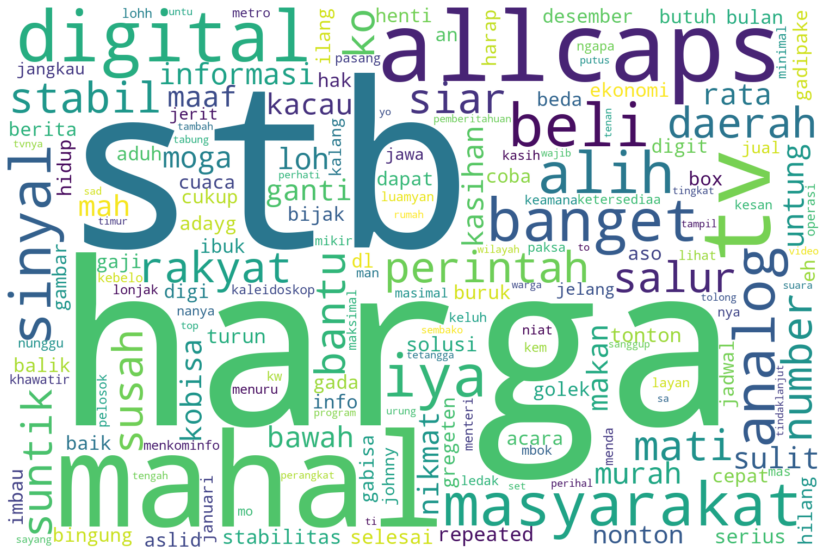

In [83]:
PlotWordCloud(d)

##Cek emosi untuk Semua label

In [84]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,2))

In [85]:
Data_TFIDF = tfidf_vect.fit_transform(dataset["ProcessedText"].values)

In [86]:
Data_TFIDF.shape

(250, 2020)

In [87]:
vectorizer = TfidfVectorizer(ngram_range = (1,2))

In [88]:
X = vectorizer.fit_transform(dataset["ProcessedText"].values)

In [89]:
print(X.shape)

(250, 2020)


In [90]:
features = vectorizer.get_feature_names_out()

In [91]:
features

array(['a2', 'a2 number', 'abal', ..., 'youtube video', 'zjbox',
       'zjbox allcaps'], dtype=object)

In [92]:
idfValues = vectorizer.idf_

In [93]:
d = dict(zip(features, 9 - idfValues))

In [94]:
sortedDict = sorted(d.items(), key = lambda d: d[1], reverse = True)

In [95]:
for i in range(992):
    print(sortedDict[i])

('tv', 7.586534849224759)
('digital', 7.423306951246385)
('stb', 7.349744384069368)
('allcaps', 7.294828626473253)
('tv digital', 7.137986154980283)
('harga', 6.9404551795228)
('allcaps stb', 6.8183524827219)
('stb allcaps', 6.792035174404527)
('set', 6.648934330763853)
('siar', 6.648934330763853)
('set top', 6.601681445913307)
('top', 6.601681445913307)
('box', 6.585420925041527)
('top box', 6.568891623090317)
('analog', 6.425790779449644)
('number', 6.303188457357312)
('mahal', 6.281209550638536)
('tv analog', 6.2122166791515845)
('siar tv', 6.112133220594602)
('beli', 6.058065999324326)
('harga allcaps', 5.971054622334696)
('masyarakat', 5.940282963667943)
('harga stb', 5.908534265353362)
('alih', 5.652600891216162)
('mati', 5.565589514226533)
('iya', 5.519069498591639)
('terima', 5.470279334422207)
('allcaps mahal', 5.36491881876438)
('banget', 5.36491881876438)
('box tv', 5.36491881876438)
('siar digital', 5.36491881876438)
('sinyal', 5.36491881876438)
('alih tv', 5.30776040492443

In [96]:
def PlotWordCloud(frequency):
    worcloudPlot = WordCloud(background_color="white", width=1500, height=1000)
    worcloudPlot.generate_from_frequencies(frequencies=frequency)
    plot.figure(figsize=(15,10))
    plot.imshow(worcloudPlot, interpolation="bilinear")
    plot.axis("off")
    plot.show()

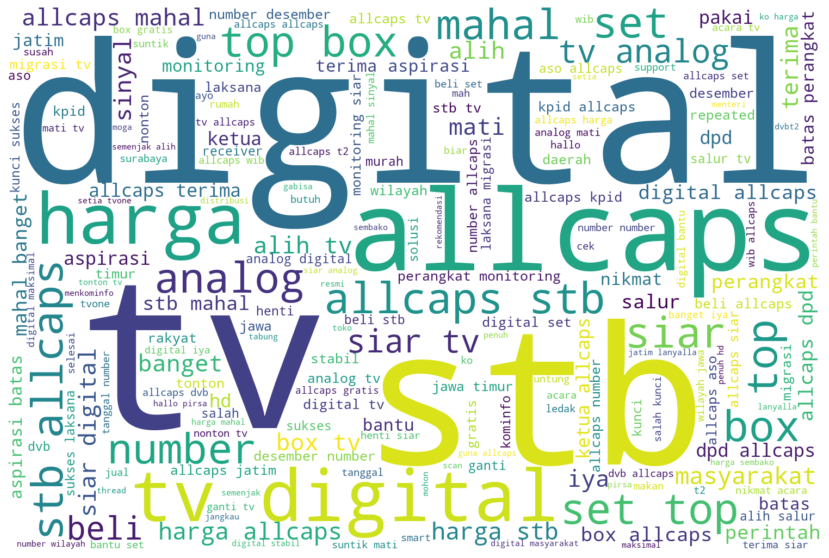

In [97]:
PlotWordCloud(d)

##Modelling

In [98]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier

In [99]:
from sklearn.pipeline import Pipeline
classifier_adb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', AdaBoostClassifier())
])

In [100]:
parameters_adb = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'model__n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20, 30],
    'model__learning_rate': [(0.97 + x / 100) for x in range(0, 8)], 
    'model__algorithm': ['SAMME', 'SAMME.R']
}

In [101]:
classifier_adb = GridSearchCV(classifier_adb, parameters_adb, cv = 10, verbose=1, n_jobs=-1)

In [102]:
classifier_adb.fit(train_x, train_label)

Fitting 10 folds for each of 896 candidates, totalling 8960 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('model', AdaBoostClassifier())]),
             n_jobs=-1,
             param_grid={'model__algorithm': ['SAMME', 'SAMME.R'],
                         'model__learning_rate': [0.97, 0.98, 0.99, 1.0, 1.01,
                                                  1.02, 1.03, 1.04],
                         'model__n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                 11, 12, 20, 30],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                (1, 4)]},
             verbose=1)

In [103]:
y_pred_adb_train = classifier_adb.predict(train_x)
accuracy_adb_train = accuracy_score(train_label, y_pred_adb_train)
print("Accuracy Training set: ", accuracy_adb_train)

y_pred_adb_test = classifier_adb.predict(test_x)
accuracy_adb_test = accuracy_score(test_label, y_pred_adb_test)
print("Accuracy Test set: ", accuracy_adb_test)

Accuracy Training set:  0.816
Accuracy Test set:  0.712


In [104]:
recall_adb_train = recall_score(train_label, y_pred_adb_train, average='weighted')
print("Recall Training set: ", recall_adb_train)

recall_adb_test = recall_score(test_label, y_pred_adb_test, average='weighted')
print("Recall Test set: ", recall_adb_test)

Recall Training set:  0.816
Recall Test set:  0.712


In [105]:
precision_adb_train = precision_score(train_label, y_pred_adb_train, average='weighted')
print("Precision Training set: ", precision_adb_train)

precision_adb_test = precision_score(test_label, y_pred_adb_test, average='weighted')
print("Precision Test set: ", precision_adb_test)

Precision Training set:  0.8241617717862302
Precision Test set:  0.7103116411718952


In [106]:
f1_adb_train = f1_score(train_label, y_pred_adb_train, average='weighted')
print("F1 Training set: ", f1_adb_train)

f1_adb_test = f1_score(test_label, y_pred_adb_test, average='weighted')
print("F1 Test set: ", f1_adb_test)

F1 Training set:  0.8158489099330932
F1 Test set:  0.7045030977575525


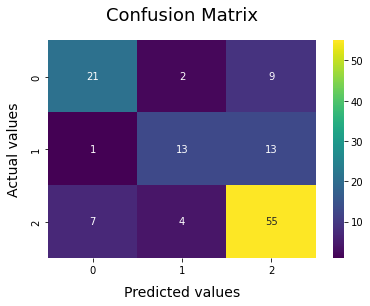

In [107]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_label, y_pred_adb_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

In [108]:
from sklearn.metrics import classification_report

In [109]:
print("\nThe Classification Report for Validation Set  is\n\n ", classification_report(test_label,y_pred_adb_test)) 


The Classification Report for Validation Set  is

                precision    recall  f1-score   support

           0       0.72      0.66      0.69        32
           1       0.68      0.48      0.57        27
           2       0.71      0.83      0.77        66

    accuracy                           0.71       125
   macro avg       0.71      0.66      0.67       125
weighted avg       0.71      0.71      0.70       125



In [110]:
classifier_adb.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('model',
                 AdaBoostClassifier(learning_rate=0.99, n_estimators=20))])

In [111]:
for param_name in sorted(parameters_adb.keys()):
    print("%s: %r" % (param_name, classifier_adb.best_params_[param_name]))

model__algorithm: 'SAMME.R'
model__learning_rate: 0.99
model__n_estimators: 20
tfidf__ngram_range: (1, 1)


In [112]:
from sklearn.linear_model import SGDClassifier

In [113]:
from sklearn.pipeline import Pipeline
classifier_s = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', SGDClassifier())
])

In [114]:
parameters_s = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'model__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'model__loss': ['hinge', 'log', 'log_loss']
}

In [115]:
classifier_s = GridSearchCV(classifier_s, parameters_s, cv = 10, verbose=1, n_jobs=-1)

In [116]:
classifier_s.fit(train_x, train_label)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('model', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                          100.0, 1000.0],
                         'model__loss': ['hinge', 'log', 'log_loss'],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                (1, 4)]},
             verbose=1)

In [117]:
y_pred_s_train = classifier_s.predict(train_x)
accuracy_s_train = accuracy_score(train_label, y_pred_s_train)
print("Accuracy Training set: ", accuracy_s_train)

y_pred_s_test = classifier_s.predict(test_x)
accuracy_s_test = accuracy_score(test_label, y_pred_s_test)
print("Accuracy Test set: ", accuracy_s_test)

Accuracy Training set:  1.0
Accuracy Test set:  0.792


In [118]:
for param_name in sorted(parameters_s.keys()):
    print("%s: %r" % (param_name, classifier_s.best_params_[param_name]))

model__alpha: 0.0001
model__loss: 'log'
tfidf__ngram_range: (1, 1)


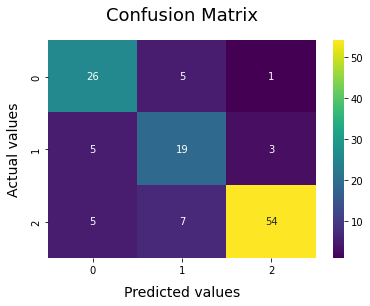

In [119]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_label, y_pred_s_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

In [120]:
print("\nThe Classification Report for Validation Set  is\n\n ", classification_report(test_label,y_pred_s_test)) 


The Classification Report for Validation Set  is

                precision    recall  f1-score   support

           0       0.72      0.81      0.76        32
           1       0.61      0.70      0.66        27
           2       0.93      0.82      0.87        66

    accuracy                           0.79       125
   macro avg       0.76      0.78      0.76       125
weighted avg       0.81      0.79      0.80       125



In [121]:
from sklearn.calibration import CalibratedClassifierCV

In [122]:
sig_clf = CalibratedClassifierCV(classifier_s, cv = 10, method = 'isotonic')

In [123]:
sig_clf.fit(train_x, train_label)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

CalibratedClassifierCV(base_estimator=GridSearchCV(cv=10,
                                                   estimator=Pipeline(steps=[('tfidf',
                                                                              TfidfVectorizer()),
                                                                             ('model',
                                                                              SGDClassifier())]),
                                                   n_jobs=-1,
                                                   param_grid={'model__alpha': [0.0001,
                                                                                0.001,
                                                                                0.01,
                                                                                0.1,
                                                                                1.0,
                                                                               

In [124]:
y_pred_nb_train = sig_clf.predict(train_x)
accuracy_nb_train = accuracy_score(train_label, y_pred_nb_train)
print("Accuracy Training set: ", accuracy_nb_train)

y_pred_nb_test = sig_clf.predict(test_x)
accuracy_nb_test = accuracy_score(test_label, y_pred_nb_test)
print("Accuracy Test set: ", accuracy_nb_test)

Accuracy Training set:  1.0
Accuracy Test set:  0.752


In [125]:
sig_clf2 = CalibratedClassifierCV(classifier_s, cv = 10, method = 'sigmoid')

In [126]:
sig_clf2.fit(train_x, train_label)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/usr/local/lib/python3.8/di

CalibratedClassifierCV(base_estimator=GridSearchCV(cv=10,
                                                   estimator=Pipeline(steps=[('tfidf',
                                                                              TfidfVectorizer()),
                                                                             ('model',
                                                                              SGDClassifier())]),
                                                   n_jobs=-1,
                                                   param_grid={'model__alpha': [0.0001,
                                                                                0.001,
                                                                                0.01,
                                                                                0.1,
                                                                                1.0,
                                                                               

In [127]:
y_pred_cc_train = sig_clf2.predict(train_x)
accuracy_cc_train = accuracy_score(train_label, y_pred_cc_train)
print("Accuracy Training set: ", accuracy_cc_train)

y_pred_cc_test = sig_clf2.predict(test_x)
accuracy_cc_test = accuracy_score(test_label, y_pred_cc_test)
print("Accuracy Test set: ", accuracy_cc_test)

Accuracy Training set:  1.0
Accuracy Test set:  0.8


In [128]:
print("\nThe Classification Report for Validation Set  is\n\n ", classification_report(test_label,y_pred_cc_test)) 


The Classification Report for Validation Set  is

                precision    recall  f1-score   support

           0       0.76      0.78      0.77        32
           1       0.63      0.70      0.67        27
           2       0.90      0.85      0.88        66

    accuracy                           0.80       125
   macro avg       0.76      0.78      0.77       125
weighted avg       0.81      0.80      0.80       125



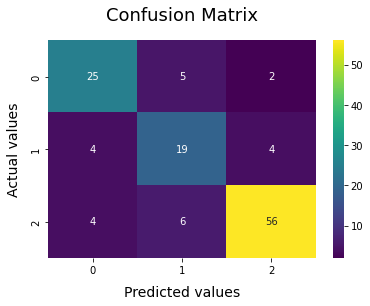

In [129]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_label, y_pred_cc_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

Kesimpulan : 
Kesimpulan yang dapat ditarik dari penelitian ini adalah hasil analisis sentimen terhadap STB, banyak yang menganggap ini sebagai sesuatu yang positif. Sentimen netral di sini bisa jadi menandakan bahwa penggunaan STB masih dipertanyakan publik. Sentimen positif menunjukkan bahwa banyak orang senang dengan STB dan beralih ke TV Digital karena tampilannya lebih bagus dan saluran TV semakin banyak. Sentimen negatif menunjukkan bahwa kebijakan transisi ini masih memiliki kekurangan dan masih perlu diperbaiki. Yang dapat ditarik dari analisis ini adalah pemerintah perlu lebih memperhatikan setiap tweet yang mengandung sentimen negatif untuk evaluasi kebijakan TV Digital ke depan. Dari sisi model, model Calibrated Classifier berbasis tuning SGDC memiliki akurasi yang lebih baik dibandingkan hanya menggunakan tuning SGDC saja. Hal ini dibuktikan dengan akurasi jarak sebesar antara 0,8 - 1,6%. Modul kalibrasi memungkinkan model untuk mengkalibrasi probabilitas model tertentu dengan lebih baik atau menambahkan dukungan untuk prediksi probabilitas.

Best Parameter : 
*   (model__alpha: 0.0001)
*   (model__loss: 'log')
*   (tfidf__ngram_range: (1, 1))

Best method dalam CC = sigmoid